In [78]:

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
import numpy as np
from scipy.stats import randint
import xgboost as xgb
from xgboost import XGBClassifier

In [79]:
DATA_PATH = "../data/processed_spotify_songs.csv"
TARGET_COLUMN = "track_popularity"

In [80]:
df = pd.read_csv(DATA_PATH)

In [81]:
df.head()

,track_artist,track_popularity,track_album_id,track_album_release_date,playlist_id,playlist_subgenre,danceability,energy,key,loudness,...,rap,latin,rock,pop,artist_track_encoded,playlist_id_encoded,track_album_id_encoded,release_year,release_month,release_day
0,Barbie's Cradle,41.0,1srJQ0njEQgd8w4XSqI4JQ,2001-01-01,37i9dQZF1DWYDQ8wBxd7xt,classic rock,0.481351,0.160801,2.0,0.588413,...,0,0,1,0,43.5,43.100000,41.0,2001,1,1
1,RIKA,15.0,1ficfUnZMaY1QkNp15Slzm,2018-01-26,0JmBB9HfrzDiZoPVRdv8ns,neo soul,0.350541,0.495616,5.0,0.715122,...,0,0,0,0,15.0,26.206186,15.0,2018,1,26
2,Steady Rollin,28.0,3z04Lb9Dsilqw68SHt6jLB,2017-11-21,3YouF0u7waJnolytf9JCXf,hard rock,0.095012,0.774400,9.0,0.768273,...,0,0,1,0,29.5,31.697917,28.0,2017,11,21
3,The.madpix.project,24.0,1Z4ANBVuhTlS6DprlP0m1q,2015-08-07,5TiiHps0hNCyQ6ijVkNZQs,electropop,0.449432,0.630436,10.0,0.736041,...,0,0,0,1,12.2,39.436364,24.0,2015,8,7
4,YOSA & TAAR,38.0,2BuYm9UcKvI0ydXs5JKwt0,2018-11-16,37i9dQZF1DXdOtZGKonFlM,dance pop,0.453533,0.702244,1.0,0.713109,...,0,0,0,1,38.0,35.673469,38.0,2018,11,16


### A little pre-processing 

In [82]:
### REMOVE some useless columns

df = df.drop(columns=["track_artist","track_album_id","track_album_release_date","playlist_id","playlist_subgenre"])


In [83]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28352 entries, 0 to 28351
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_popularity        28352 non-null  float64
 1   danceability            28352 non-null  float64
 2   energy                  28352 non-null  float64
 3   key                     28352 non-null  float64
 4   loudness                28352 non-null  float64
 5   mode                    28352 non-null  int64  
 6   speechiness             28352 non-null  float64
 7   acousticness            28352 non-null  float64
 8   instrumentalness        28352 non-null  float64
 9   liveness                28352 non-null  float64
 10  valence                 28352 non-null  float64
 11  tempo                   28352 non-null  float64
 12  duration_ms             28352 non-null  float64
 13  edm                     28352 non-null  int64  
 14  r&b                     28352 non-null

We have 24 predictors for 28000 samples, nice !

### Encode target variable (`track_popularity`) into 20 sub categories

In [84]:
num_categories = 10

bins = [i * (100 / num_categories) for i in range(num_categories + 1)]
labels = list(range(0, num_categories ))  
print(labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [85]:
df['popularity_category'] = pd.cut(
    df['track_popularity'], bins=bins, labels=labels, include_lowest=True)

df = df.drop(columns=["track_popularity"])

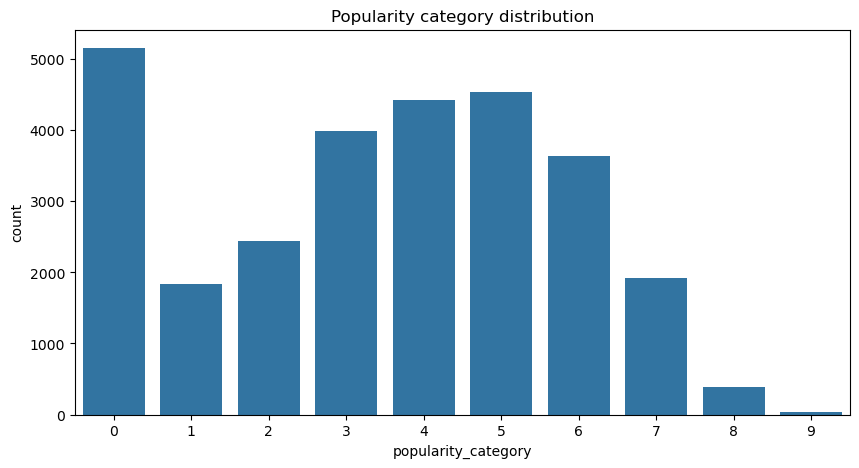

In [105]:
# plot distribution of popularity categories
plt.figure(figsize=(10, 5))
sns.countplot(x='popularity_category', data=df)
plt.title('Popularity category distribution')
plt.show()

### Split dateset

In [86]:
X = df.drop(columns=["popularity_category"])
y = df["popularity_category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
results = []

### First model - DecisionTree

In [88]:
#decision tree
trees_depth = np.arange(1,21)

train_accuracy = []
test_accuracy = []
for depth in trees_depth:
    decision_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    # use cv to get the accuracy
    cv_scores = cross_val_score(decision_tree, X_train, y_train, cv=5)
    train_accuracy.append(cv_scores.mean())
    decision_tree.fit(X_train, y_train)
    test_accuracy.append(accuracy_score(y_test, decision_tree.predict(X_test)))


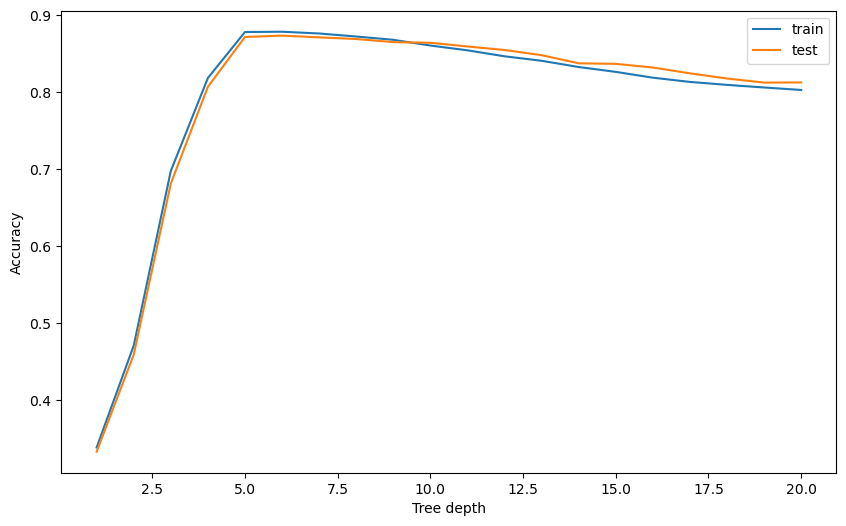

In [89]:
# plot
plt.figure(figsize=(10, 6))
plt.plot(trees_depth, train_accuracy, label="train")
plt.plot(trees_depth, test_accuracy, label="test")
plt.xlabel("Tree depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [90]:
# get the best depth
best_depth = trees_depth[np.argmax(test_accuracy)]
print(f"Best depth: {best_depth}")

Best depth: 6


In [91]:
results.append([f"Decisition Tree Depth {best_depth}", max(test_accuracy)])

### Second model - Random Forest

In [92]:
param_grid = {
    'n_estimators': [200],
    'max_depth': [None,10],
    'min_samples_split': [ 5],
    'min_samples_leaf': [1]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Evaluate the model
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8621054487744666

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      1003
           1       0.86      0.83      0.84       386
           2       0.86      0.83      0.84       529
           3       0.86      0.87      0.87       772
           4       0.84      0.87      0.85       852
           5       0.83      0.86      0.84       917
           6       0.81      0.84      0.83       745
           7       0.80      0.75      0.77       379
           8       0.88      0.44      0.58        80
           9       1.00      0.88      0.93         8

    accuracy                           0.86      5671
   macro avg       0.87      0.81      0.83      5671
weighted avg       0.86      0.86      0.86      5671



In [94]:
results.append(["Random Forest", accuracy])

### Model 3 - Bagging

In [95]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0],
    'base_estimator__max_depth': [None, 10, 20],
    'base_estimator__min_samples_split': [2, 5, 10]
}

# Initialize the base estimator
base_estimator = DecisionTreeClassifier(random_state=42)

# Initialize the BaggingClassifier
bagging_clf = BaggingClassifier(
    base_estimator=base_estimator,
    bootstrap=True,
    random_state=42
)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search_bagging = GridSearchCV(
    estimator=bagging_clf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV to the resampled training data
grid_search_bagging.fit(X_train, y_train)

# Best parameters
print("Best Parameters for BaggingClassifier:",
      grid_search_bagging.best_params_)

# Use the best estimator
best_bagging_clf = grid_search_bagging.best_estimator_

# Predictions
y_pred_bagging = best_bagging_clf.predict(X_test)

accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
# Evaluation
print("Classification Report for BaggingClassifier:\n",
      accuracy_bagging)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/en

Best Parameters for BaggingClassifier: {'base_estimator__max_depth': 20, 'base_estimator__min_samples_split': 10, 'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}
Classification Report for BaggingClassifier:
 0.8746252865455828


In [96]:
results.append(["Bagging Classifier", accuracy_bagging])

### Model 4 - Boosting

#### GradientBoosting

In [97]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=gb_clf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV to the resampled training data
grid_search_gb.fit(X_train, y_train)

# Best parameters
print("Best Parameters for GradientBoostingClassifier:",
      grid_search_gb.best_params_)

# Use the best estimator
best_gb_clf = grid_search_gb.best_estimator_

# Predictions
y_pred_gb = best_gb_clf.predict(X_test)

accuracy_gb = accuracy_score(y_test, y_pred_gb)
# Evaluation
print("Classification Report for GradientBoostingClassifier:\n",
      accuracy_gb)

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best Parameters for GradientBoostingClassifier: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.6}
Classification Report for GradientBoostingClassifier:
 0.8733909363427966


 {'learning_rate': 0.01, 'max_depth': 3, 'max_features': None, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.6}

In [98]:
results.append(["Gradient Boosting Classifier", accuracy_gb])

#### AdaBoost

In [99]:
param_grid = {
    'n_estimators': [50, 100, 150],          # Number of weak learners
    # Learning rate shrinks the contribution of each classifier
    'learning_rate': [0.01, 0.1, 1],
    # Maximum depth of the base estimator (weak learner)
    'base_estimator__max_depth': [1, 3, 5],
    # Minimum samples to split a node
    'base_estimator__min_samples_split': [2, 5, 10]
}

# Initialize the base estimator (weak learner)
base_estimator = DecisionTreeClassifier(random_state=42)

# Initialize the AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    base_estimator=base_estimator,
    random_state=42
)

# Initialize GridSearchCV
grid_search_ada = GridSearchCV(
    estimator=ada_clf,
    param_grid=param_grid,
    scoring='f1_weighted',  # Scoring metric for imbalanced datasets
    cv=3,                  # 3-fold cross-validation
    n_jobs=-1,             # Use all available cores
    verbose=1              # Print progress during search
)

# Fit the GridSearchCV to the resampled training data
grid_search_ada.fit(X_train, y_train)

# Best parameters
print("Best Parameters for AdaBoostClassifier:", grid_search_ada.best_params_)

# Use the best estimator
best_ada_clf = grid_search_ada.best_estimator_

# Predictions
y_pred_ada = best_ada_clf.predict(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_ada)

# Evaluation
print("Classification Report for AdaBoostClassifier:\n",
        accuracy_ada)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/sklearn/en

Best Parameters for AdaBoostClassifier: {'base_estimator__max_depth': 5, 'base_estimator__min_samples_split': 2, 'learning_rate': 0.01, 'n_estimators': 50}
Classification Report for AdaBoostClassifier:
 0.8735672720860519


In [100]:
results.append(["AdaBoost Classifier", accuracy_ada])

#### XGBoost

In [104]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}


# Initialize the XGBClassifier
xgb_clf = XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y)),
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the GridSearchCV to the resampled training data
grid_search_xgb.fit(X_train, y_train)

# Best parameters
print("Best Parameters for XGBClassifier:", grid_search_xgb.best_params_)

# Use the best estimator
best_xgb_clf = grid_search_xgb.best_estimator_

# Predictions
y_pred_xgb = best_xgb_clf.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
# Evaluation
print("Classification Report for XGBClassifier:\n",
        accuracy_xgb)

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:15:27] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:15:27] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/eliotatlani/opt/anaconda3/envs/hit_predict/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:15:27] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warning

KeyboardInterrupt: 

In [102]:
results.append(["XGB Classifier", accuracy_xgb])

### Results

In [103]:
df_results = pd.DataFrame(results, columns=["Model", "Accuracy"])
print(df_results)

                          Model  Accuracy
0       Decisition Tree Depth 6  0.873567
1                 Random Forest  0.862105
2            Bagging Classifier  0.874625
3  Gradient Boosting Classifier  0.873391
4           AdaBoost Classifier  0.873567
5                XGB Classifier  0.873215
